# LIGO/Virgo maps, I/O and resampling

On this example we'll use LIGO/Virgo skymaps as an excuse to see how to open/write a map to/from disc, how create a multi-resolution maps out of a single-resolution map, and how to resample an already multi-resolution map.

## Reading a map

Both single and mult-resolution maps are stored in FITS files. While you can download a map and then provide the local path, you can also use the URL directly, e.g.

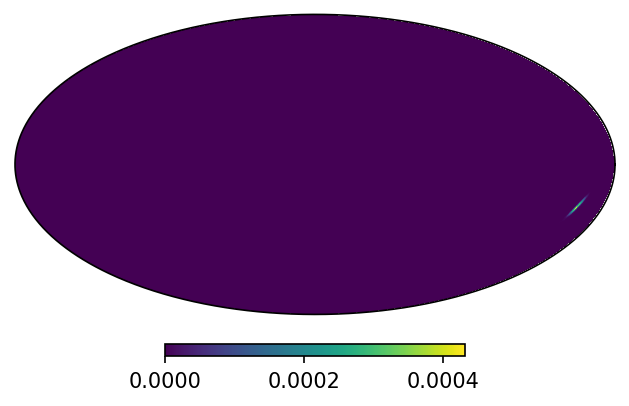

In [1]:
from mhealpy import HealpixMap

# GW170817!
m = HealpixMap.read_map("https://dcc.ligo.org/public/0157/P1800381/007/GW170817_skymap.fits.gz", density = False)

m.plot();

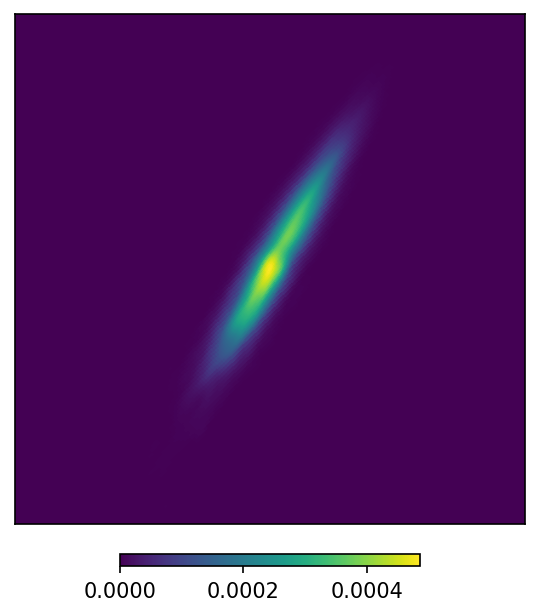

In [2]:
# Zoom in around the maximum

import numpy as np

theta_max,phi_max = m.pix2ang(np.argmax(m))

lonra = np.rad2deg(phi_max) + np.array([-10,10])
latra = (90-np.rad2deg(theta_max)) + np.array([-10,10])

m.plot(ax = 'cartview', ax_kw = {'latra': latra, 'lonra': lonra});

## Single to multi-resolution

The map we just opened is a single resolution map. Since this is a well-localized event the full sky is sampled at a relatively high resolution.

In [3]:
print("Is multi-resolution? {}".format(True if m.is_moc else False))
print("nside: {}".format(m.nside))
print("# of pixels: {}".format(m.npix))

Is multi-resolution? False
nside: 1024
# of pixels: 12582912


We can create a multi-resolution map by setting the condition that the probability assigned to any given pixel is at most the maximum value of the current single-resolution map. This mitigates the loss of information and results in a fair sampling for all locations.

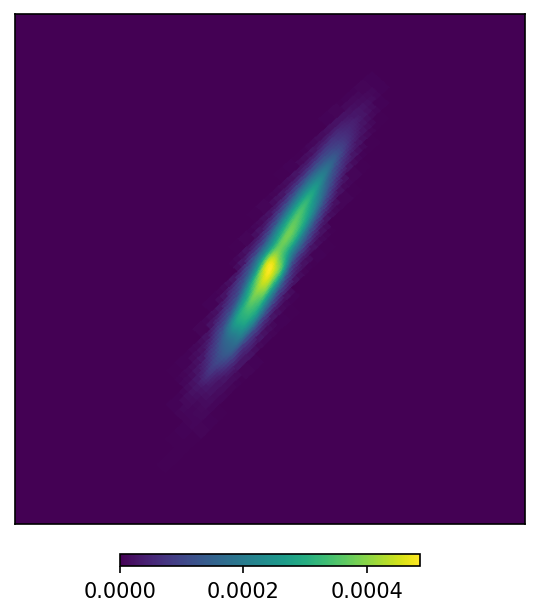

In [4]:
mm = m.to_moc(max_value = max(m))

mm.plot(ax = 'cartview', ax_kw = {'latra': latra, 'lonra': lonra});

While this plot looks pretty much the same as before, we reduced the number of pixels by 3 orders to magnitude. 

In [5]:
print("Is multi-resolution? {}".format(True if mm.is_moc else False))
print("nside: {}".format(mm.nside))
print("# of pixels: {}".format(mm.npix))

Is multi-resolution? True
nside: 1024
# of pixels: 4026


We can see the way this works more clearly by superimposing the grid

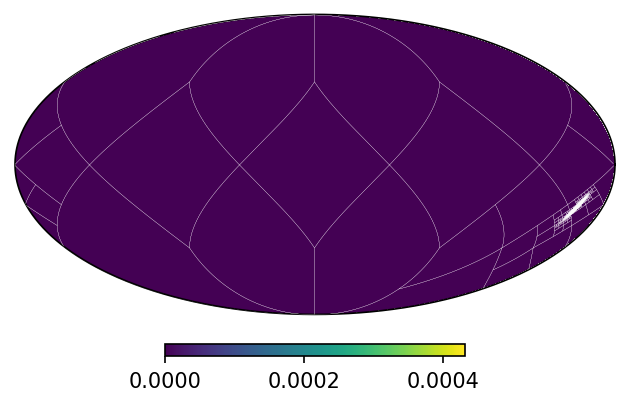

In [6]:
import matplotlib.pyplot as plt

mm.plot()
mm.plot_grid(plt.gca(), linewidth = .1, color = 'white');

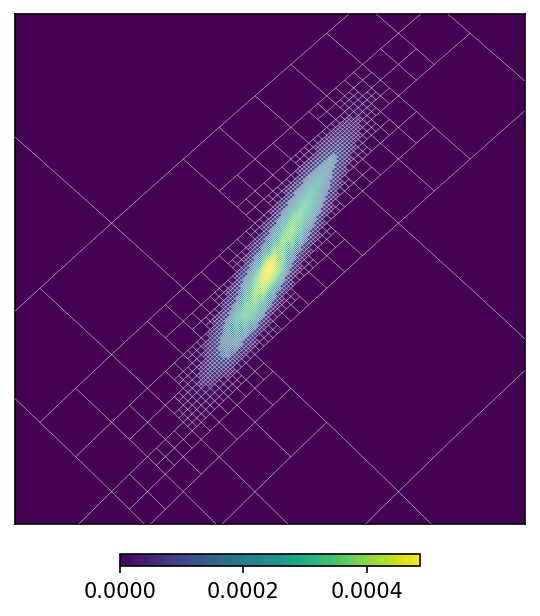

In [7]:
# Zoom in
mm.plot(ax = 'cartview', ax_kw = {'latra': latra, 'lonra': lonra})
mm.plot_grid(plt.gca(), linewidth = .1, color = 'white');

By default the equivalent to the rasterized map is plotted. That is, the previous plot is proportional to the probability *density* distribution, rather than the integrated probability on each pixel. You can changed this behaviour using the `rasterize` option. 

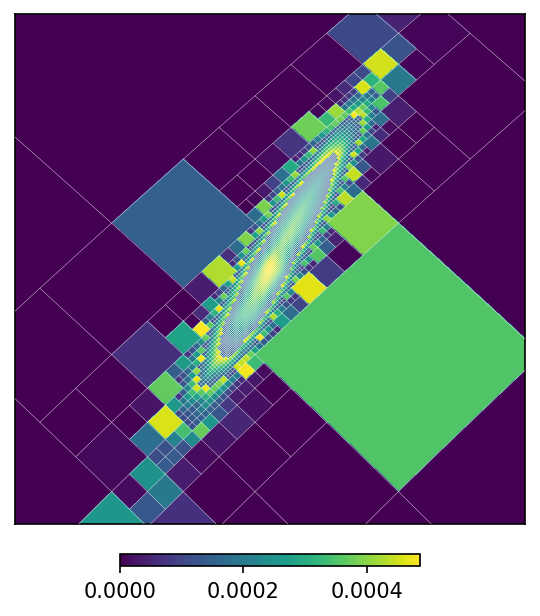

In [8]:
mm.plot(ax = 'cartview', ax_kw = {'latra': latra, 'lonra': lonra}, rasterize = False)
mm.plot_grid(plt.gca(), linewidth = .1, color = 'white');

The function [to_moc()](../api/classes.rst#mhealpy.HealpixMap.to_moc) is a convenience routine derived from [adaptive_moc_mesh()](../api/classes.rst#mhealpy.HealpixBase.adaptive_moc_mesh). The same is true for [moc_histogram()](../api/classes.rst#mhealpy.HealpixMap.moc_histogram) and [moc_from_pixels()](../api/classes.rst#mhealpy.HealpixBase.moc_from_pixels). In the more general [adaptive_moc_mesh()](../api/classes.rst#mhealpy.HealpixBase.adaptive_moc_mesh) the user provides an arbitrary function that decides, recusively, whether a pixel must be split into child pixels of higher order or remain as a single pixel.

## Resampling multi-resolution maps

For new gravitational wave events LIGO/Virgo also provides multi-resolution maps straight out the box, e.g.

Is multi-resolution? True
nside: 512
# of pixels: 16896


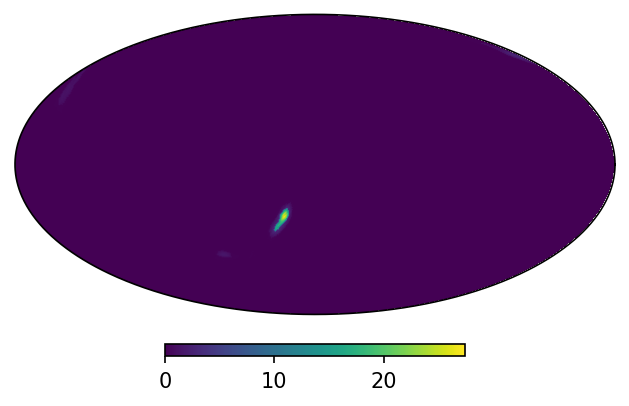

In [9]:
from mhealpy import HealpixMap

m = HealpixMap.read_map("https://gracedb.ligo.org/api/superevents/S200219ac/files/LALInference.multiorder.fits,0", density = False)

print("Is multi-resolution? {}".format(True if m.is_moc else False))
print("nside: {}".format(m.nside))
print("# of pixels: {}".format(m.npix))

m.plot();

The grid though corresponds to the adaptive mesh used to generate the sky localization:

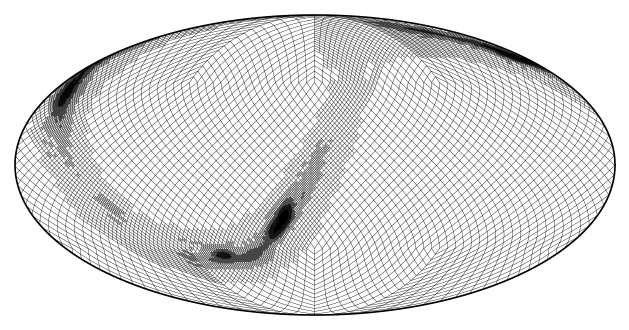

In [10]:
m.plot_grid(linewidth = .1);

We can resample it the same way we did for the single-resolution map:

Is multi-resolution? True
nside: 512
# of pixels: 5616


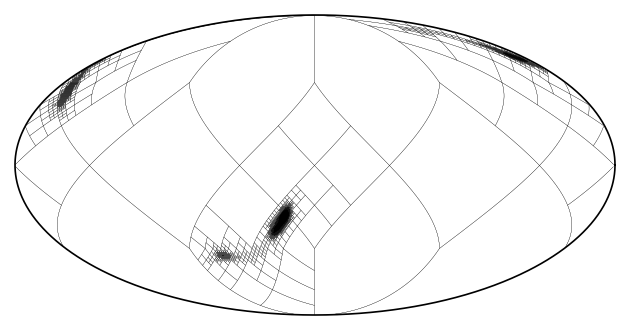

In [11]:
mm = m.to_moc(max(m))

print("Is multi-resolution? {}".format(True if mm.is_moc else False))
print("nside: {}".format(mm.nside))
print("# of pixels: {}".format(mm.npix))

mm.plot_grid(linewidth = .1);

While only a modest improvement in this case, resampling can be useful when the map is the product of maps from multiple sources. As seen in the quick start tutorial, in order to assure there is no information loss, the grid resulting from an operation is the union of the grid of its operands. This can result in high resolution in regions where it is no longer needed.

## Writing a map to disc

We can now save this resampled map to disc.

In [12]:
mm.write_map("S200219ac_LALInference_resampled.multiorder.fits")

The format is compliant with the the [IVOA MOC recommendation](https://www.ivoa.net/documents/MOC). The map is saved into the second (0-th indexed) HDU as an extension table, each pixel specified explicitely by its UNIQ number:

In [13]:
from astropy.io import fits

f = fits.open("S200219ac_LALInference_resampled.multiorder.fits")

f[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   16 / length of dimension 1                          
NAXIS2  =                 5616 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    2 / number of table fields                         
TTYPE1  = 'UNIQ    '                                                            
TFORM1  = 'K       '                                                            
TTYPE2  = 'CONTENTS'                                                            
TFORM2  = 'D       '                                                            
PIXTYPE = 'HEALPIX '        